##### Load modules

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

##### Load and preprocess data

In [2]:
df_train = pd.read_csv('train.csv')
df_train['text'] = [f'{t} EOT {k}' for idx, (t, k) in df_train[['text', 'keyword']].iterrows()]
df_train = df_train[['text', 'target']]

##### Split train/valid/test

In [3]:
def sample_from_dataframe(df, n_sample):
    params = {'n': n_sample, 'random_state': 0}

    where = df.target == 0
    df_sample = df[where].sample(**params)

    where = df.target == 1
    df_sample = pd.concat([df_sample, df[where].sample(**params)])

    return df.drop(index=df_sample.index), df_sample

In [4]:
df_train, df_valid = sample_from_dataframe(df_train, 500)
df_train, df_test = sample_from_dataframe(df_train, 200)

In [5]:
df_train.shape, df_valid.shape, df_test.shape

((6213, 2), (1000, 2), (400, 2))

##### Tokenize text

In [6]:
def text_to_seq(tokenizer, df):
    seqs = tokenizer.texts_to_sequences(df.text)
    x = keras.preprocessing.sequence.pad_sequences(seqs)
    y = df.target.values
    return x, y

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.text)

x_train, y_train = text_to_seq(tokenizer, df_train)
x_valid, y_valid = text_to_seq(tokenizer, df_valid)
x_test, y_test = text_to_seq(tokenizer, df_test)

In [8]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((6213, 35), (6213,), (1000, 31), (1000,), (400, 33), (400,))

##### Build and train a network

In [9]:
def build(n_words):
    params = {
        'dropout': 0.5,
        'recurrent_dropout': 0.5,
    }

    K.clear_session()

    inputs = keras.layers.Input(shape=(None, ))
    prev = keras.layers.Embedding(n_words, 64, mask_zero=True)(inputs)
    prev = keras.layers.LSTM(64, return_sequences=True, **params)(prev)
    prev = keras.layers.LSTM(64, return_sequences=True, **params)(prev)
    prev = keras.layers.LSTM(64, **params)(prev)
    outputs = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')(prev)

    model = keras.models.Model(inputs, outputs)
    
    return model

Train on 6213 samples, validate on 1000 samples
Epoch 1/20
6213/6213 [==============================] - 10s 2ms/sample - loss: 0.6464 - accuracy: 0.6588 - val_loss: 0.5319 - val_accuracy: 0.7700
Epoch 2/20
6213/6213 [==============================] - 3s 500us/sample - loss: 0.4757 - accuracy: 0.8099 - val_loss: 0.4828 - val_accuracy: 0.7880
Epoch 3/20
6213/6213 [==============================] - 3s 498us/sample - loss: 0.3791 - accuracy: 0.8553 - val_loss: 0.5604 - val_accuracy: 0.7640
Epoch 4/20
6213/6213 [==============================] - 3s 486us/sample - loss: 0.3125 - accuracy: 0.8894 - val_loss: 0.5180 - val_accuracy: 0.7910
Epoch 5/20
6213/6213 [==============================] - 3s 515us/sample - loss: 0.2734 - accuracy: 0.9044 - val_loss: 0.5384 - val_accuracy: 0.7830
Epoch 6/20
6213/6213 [==============================] - 3s 518us/sample - loss: 0.2284 - accuracy: 0.9227 - val_loss: 0.6362 - val_accuracy: 0.7710
Epoch 7/20
6213/6213 [==============================] - 3s 503us/

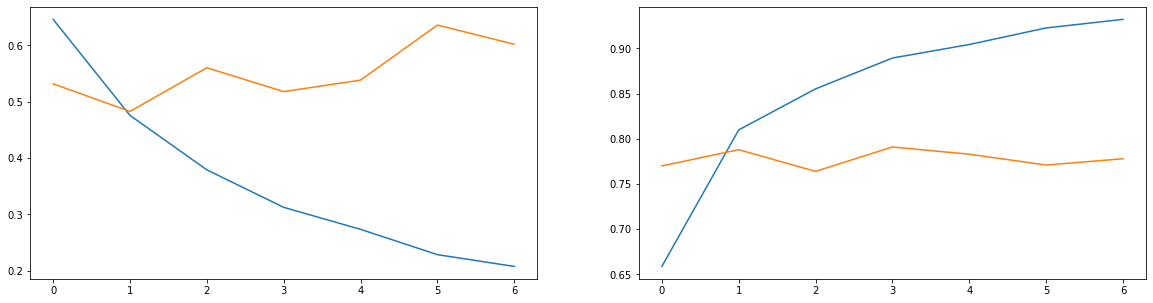

In [10]:
optimizer = keras.optimizers.RMSprop()
earlystop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = build(np.max(x_train) + 1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256, epochs=20, callbacks=[earlystop])

plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.show()

##### Evaluate on validation / test set

In [11]:
def evaluate(y_true, y_pred):
    f1 = f1_score(y_true, y_pred) * 100
    print(f'f1_score is {f1:.2f}')
    print()
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / y_true.shape[0] * 2
    ConfusionMatrixDisplay(cm, ['0', '1']).plot()
    plt.show()

f1_score is 76.02



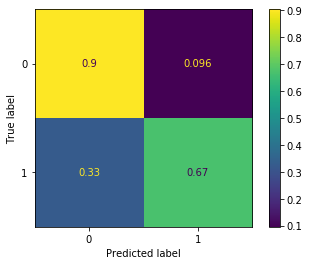

In [12]:
y_hat = model.predict(x_valid, batch_size=512)
y_pred = y_hat >= 0.5
evaluate(y_valid, y_pred)

f1_score is 77.56



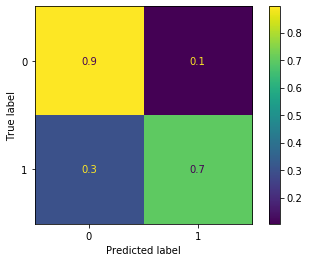

In [13]:
y_hat = model.predict(x_test, batch_size=512)
y_pred = y_hat >= 0.5
evaluate(y_test, y_pred)

##### Error diagnosis

In [14]:
pd.set_option('max_colwidth', 500)
y_hat = model.predict(x_valid, batch_size=512)
df_valid['error'] = np.abs(y_valid.reshape(-1) - y_hat.reshape(-1))
df_valid['seq'] = tokenizer.sequences_to_texts(x_valid)
df_valid.sort_values('error', ascending=False).head(30)

,text,target,error,seq
2362,7 Christians detained in Zhejiang amid widespread anger over cross removal- over 1200 crosses removed since last yr http://t.co/8PICbkDJM0 EOT demolition,0,0.953153,7 christians detained in amid widespread anger over cross removal over 1200 crosses removed since last yr http t co eot demolition
167,Statistically I'm at more of risk of getting killed by a cop than I am of dying in an airplane accident. EOT airplane%20accident,0,0.940323,i'm at more of risk of getting killed by a cop than i am of dying in an airplane accident eot airplane 20accident
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino EOT fire%20truck,0,0.934278,former township fire truck being used in philippines langley times http t co eot fire 20truck
4348,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/3eJL9lZlCH EOT hijack,0,0.931917,bayelsa poll tension in bayelsa as patience jonathan plans to hijack apc pdp plans by former first lady and http t co eot hijack
1029,BREAKING: Fairfax County firefighter placed on admin leave amid probe into Facebook post about putting police in 'body bags' dept. says. EOT body%20bags,0,0.927378,breaking county firefighter on admin leave amid probe into facebook post about putting police in 'body dept says eot body 20bags
1005,'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek. EOT body%20bagging,1,0.918874,'i did another one i did another one you still ain't done shit about the other one ' nigga body bagging meek eot body 20bagging
974,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/iap4LwvqsW EOT body%20bag,1,0.916632,new ladies shoulder tote handbag faux leather hobo purse cross body bag womens http t co zujwuiomb3 http t co eot body 20bag
4143,@leedsrouge Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL EOT harm,1,0.906667,love what you picked we're playing worth it by fifth harm kid ink because of you listen amp vote http t co 0wratka2jl eot harm
6108,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F EOT sinking,1,0.904890,do you feel like you are sinking in low self image take the quiz http t co http t co eot sinking
4618,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring EOT injury,0,0.901556,cleared incident with injury i 495 inner loop exit 31 md 97 georgia ave silver spring eot injury
